In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/PhalangesOutlinesCorrect/"

In [5]:
dataset_name = "phalanges"

In [6]:
X = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TRAIN.txt", header=None, delim_whitespace=True)
y_all = np.array(X[0]).astype("int")
#y_all[y_all == -1] = 0

X_all = X.iloc[:,1:].values
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [7]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (1800, 80, 1)
y SHAPE:  (1800,)

CLASSES BALANCE
0 :  0.35
1 :  0.65


In [8]:
X_test = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TEST.txt", header=None, delim_whitespace=True)
y_test = np.array(X_test[0]).astype("int")
#y_all[y_all == -1] = 0

X_test = X_test.iloc[:,1:].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
print("X SHAPE: ", X_test.shape)
print("y SHAPE: ", y_test.shape)

X SHAPE:  (858, 80, 1)
y SHAPE:  (858,)


## DATASET SPLIT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (1008, 80, 1)
BLACKBOX VALIDATION SET:  (252, 80, 1)
BLACKBOX TEST SET:  (858, 80, 1)
EXPLANATION TRAINING SET:  (345, 80, 1)
EXPLANATION VALIDATION SET:  (87, 80, 1)
EXPLANATION TEST SET:  (108, 80, 1)


In [12]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  80
N. LABELS:  2


# BLACKBOX MODEL

In [13]:
"""import importlib
importlib.reload(blackboxes)"""
import keras
from sklearn.metrics import accuracy_score, mean_squared_error
from joblib import dump, load
import time
from blackboxes import *
import blackboxes

Using TensorFlow backend.


## resnet

In [14]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_resnet_20191101_164247_best_weights_+0.86_.hdf5")
resnet = blackbox

## simple CNN

In [15]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_170209_best_weights_+0.83_.hdf5")
simplecnn = blackbox

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [17]:
knn = load(parentdir + "/blackbox_checkpoints/phalanges_blackbox_knn_20191101_171534.joblib")

# AUTOENCODER

In [18]:
"""import importlib
importlib.reload(autoencoders)"""
import autoencoders
from autoencoders import *

## Standard

In [19]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 40,
          "encoder_latent_layer_type": "simple",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,2]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/phalanges_autoencoder_20191103_211535_best_weights_+0.0010_.hdf5")

# NEIGHBORHOOD GENERATION

In [20]:
"""import importlib
importlib.reload(agnosticlocalexplainer)"""
import agnosticlocalexplainer
from agnosticlocalexplainer import *

/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [21]:
index_to_explain = 0

## RESNET

In [22]:
blackbox = resnet

In [23]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [24]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [25]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	214   	0.758728	0.496654	0.993143
2  	220   	0.972919	0.496654	0.993143
3  	217   	0.98087 	0.499046	0.993175
4  	205   	0.974976	0.498782	0.993261
5  	211   	0.98094 	0.499105	0.993258
6  	216   	0.980927	0.498675	0.993258
7  	210   	0.980968	0.499126	0.993258
8  	213   	0.986897	0.499371	0.993258
9  	214   	0.973077	0.498105	0.993258
10 	213   	0.986924	0.499292	0.993258
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	212   	0.51159	0.49877	0.992811
2  	207   	0.53916	0.497984	0.993015
3  	211   	0.554821	0.49803 	0.993015
4  	201   	0.584386	0.498678	0.992951
5  	210   	0.645444	0.498548	0.992937
6  	222   	0.655227	0.498388	0.992937
7  	213   	0.682778	0.498248	0.992937
8  	204   	0.690639	0.498069	0.992989
9  	217   	0.702509	0.498428	0.992989
10 	200   	0.716312	0.498165	0.992951
synthetic neighborhood class counts {0: 882, 1: 267}


In [26]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [27]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


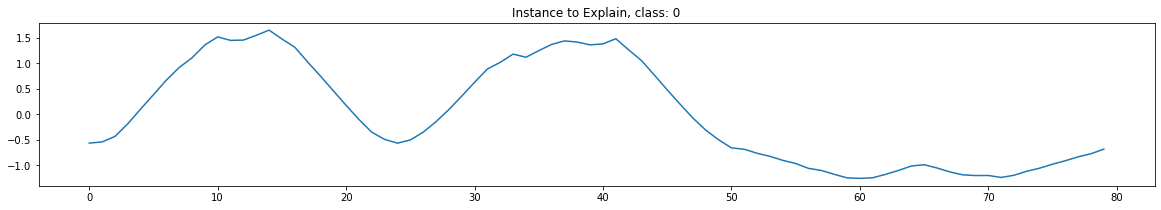

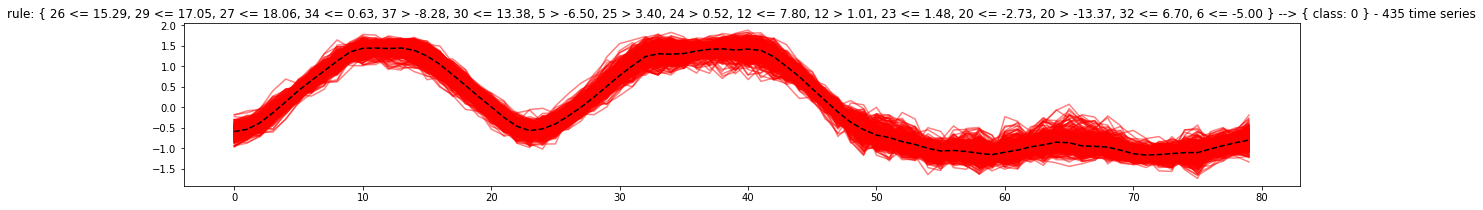

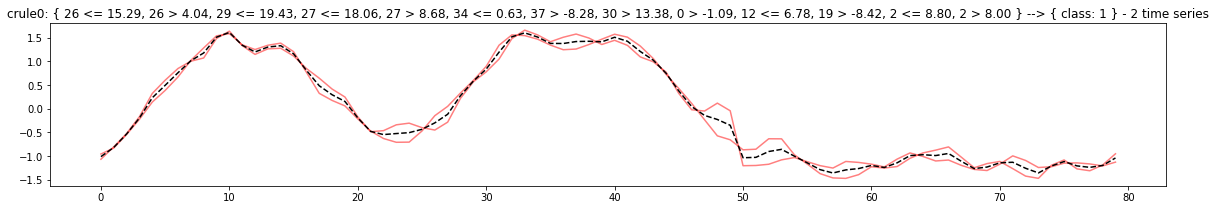

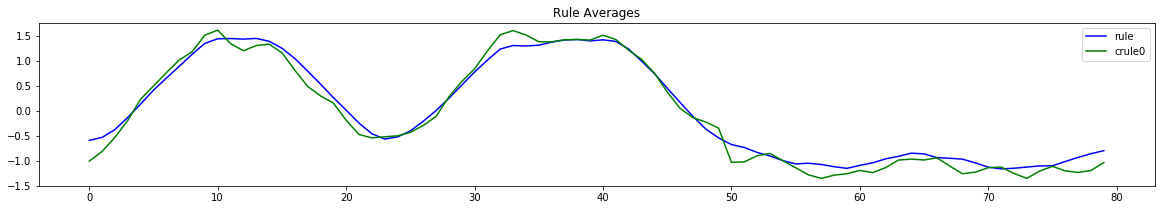

rule


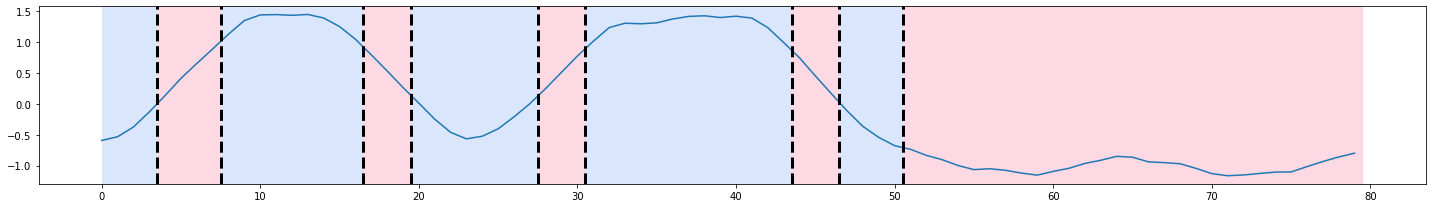

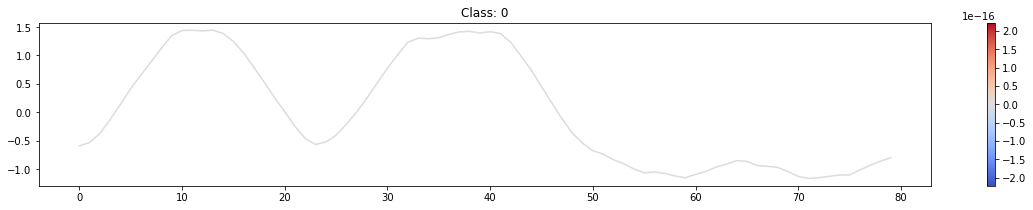

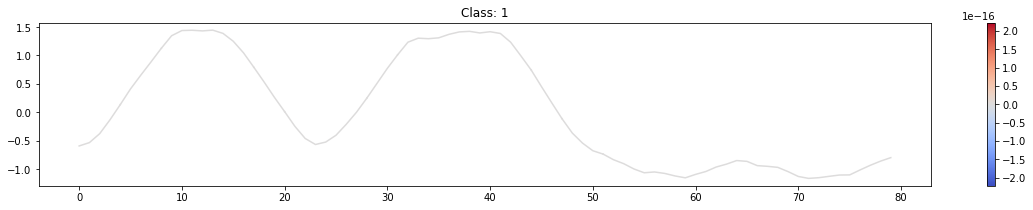

crule0


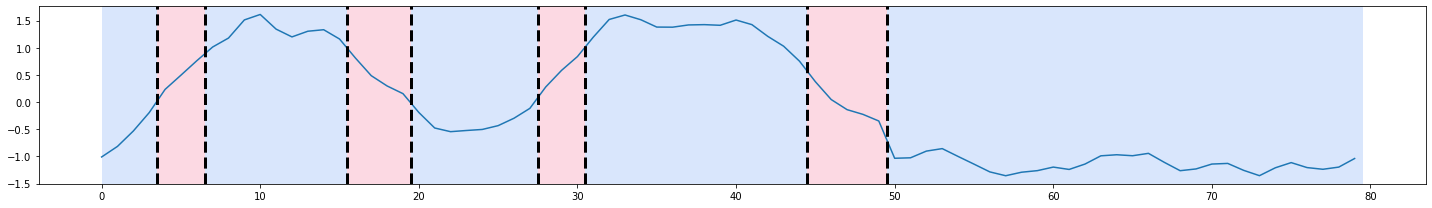

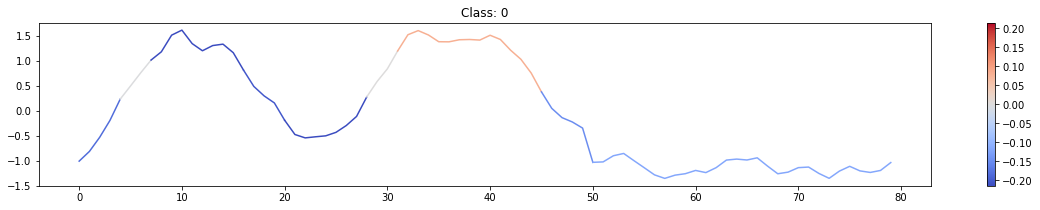

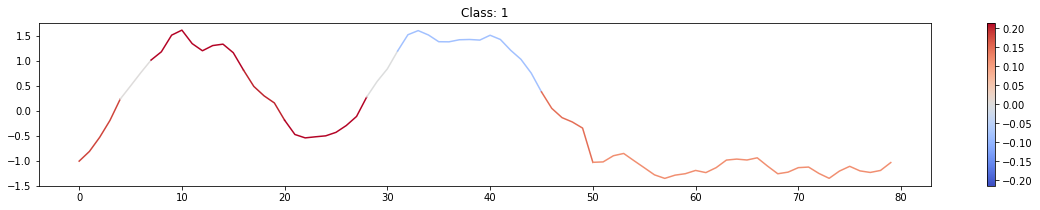

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.0s finished


rule
Rules used to predict sample 0: 
sample predicted class:  0
decision id node 0 : (shapelet n. 5 (distance = 0.0081624985) <= 0.016283869743347168)


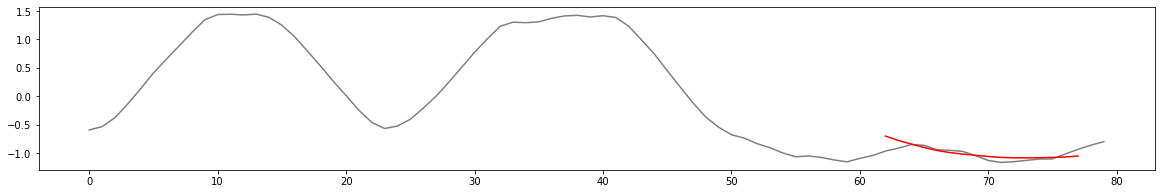

decision id node 0 : (shapelet n. 5 (distance = 0.0081624985) <= 0.016283869743347168)


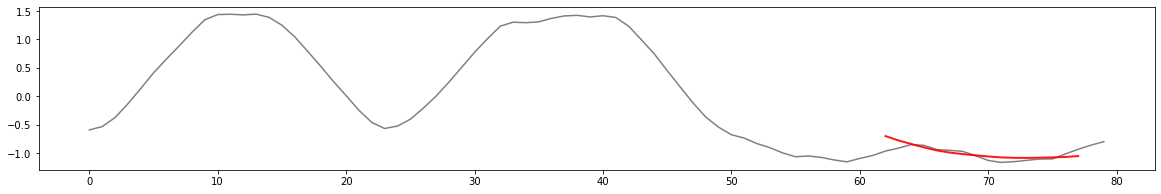

crule0
Rules used to predict sample 0: 
sample predicted class:  1
decision id node 0 : (shapelet n. 5 (distance = 0.030306816) > 0.016283869743347168)
decision id node 2 : (shapelet n. 5 (distance = 0.030306816) <= 0.031279802322387695)


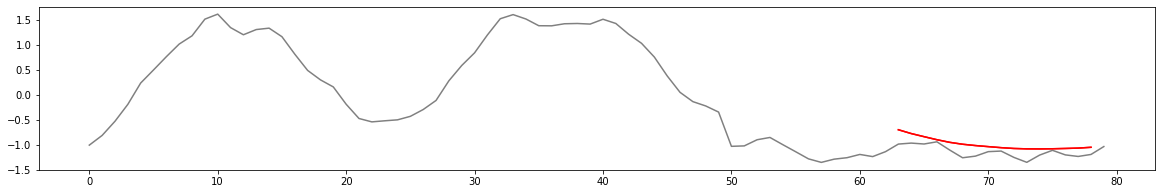

decision id node 0 : (shapelet n. 5 (distance = 0.030306816) > 0.016283869743347168)


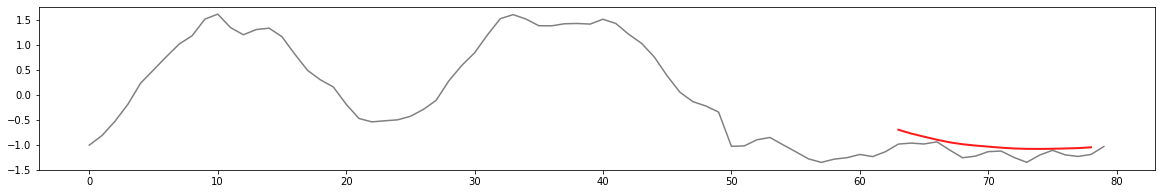

decision id node 2 : (shapelet n. 5 (distance = 0.030306816) <= 0.031279802322387695)


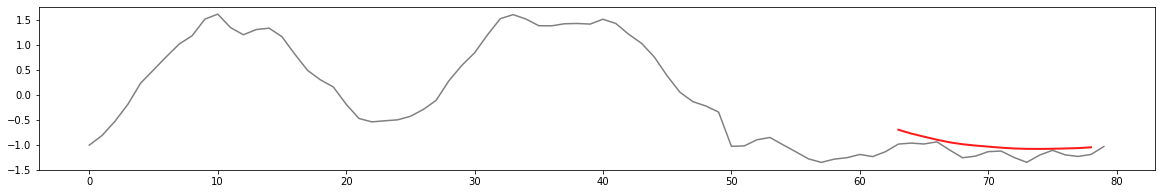

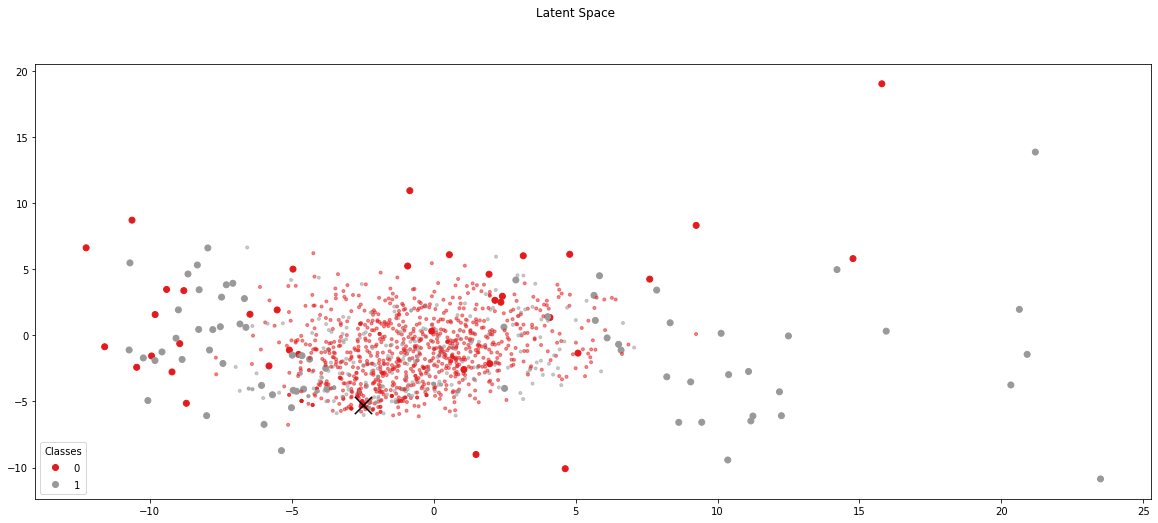

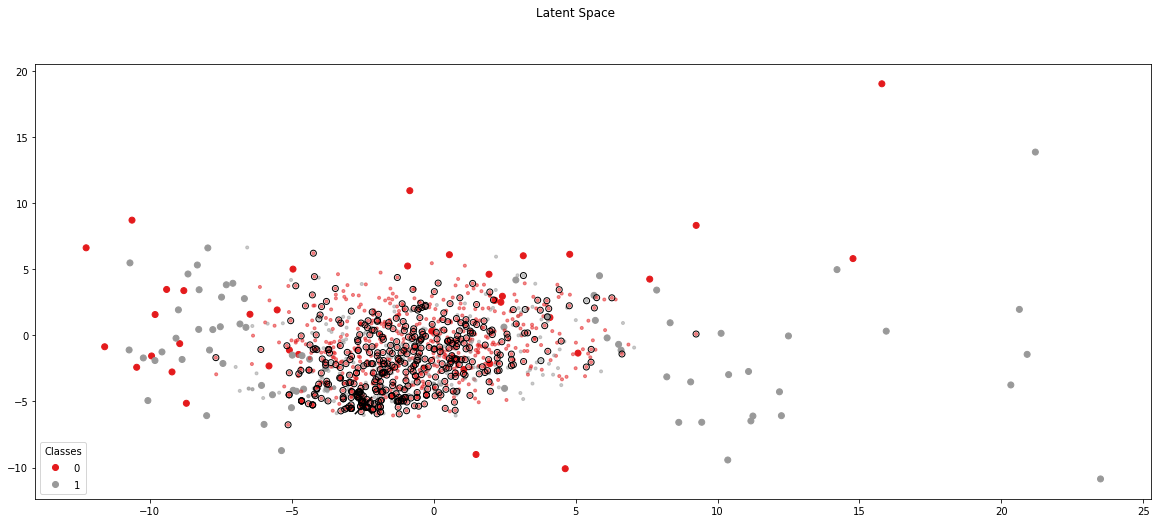

In [28]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )

## SIMPLE CNN

In [29]:
blackbox = simplecnn

In [30]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [31]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [32]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	214   	0.750835	0.496654	0.993143
2  	220   	0.94529 	0.496654	0.993143
3  	217   	0.974944	0.498361	0.993175
4  	205   	0.974976	0.498786	0.993261
5  	211   	0.982914	0.499054	0.993258
6  	216   	0.97303 	0.498832	0.993258
7  	210   	0.978993	0.49905 	0.993258
8  	213   	0.969136	0.498659	0.993258
9  	214   	0.957292	0.49899 	0.993258
10 	213   	0.979024	0.498952	0.993258
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	212   	0.519482	0.49877	0.992858
2  	207   	0.550998	0.497984	0.993101
3  	211   	0.556807	0.498661	0.993101
4  	201   	0.58442 	0.498719	0.993149
5  	210   	0.633689	0.498709	0.993149
6  	222   	0.665177	0.498421	0.993149
7  	213   	0.708551	0.498388	0.993149
8  	204   	0.724297	0.49813 	0.993149
9  	217   	0.742067	0.498474	0.993149
10 	200   	0.732221	0.498451	0.993149
synthetic neighborhood class counts {0: 854, 1: 295}


In [33]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [34]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


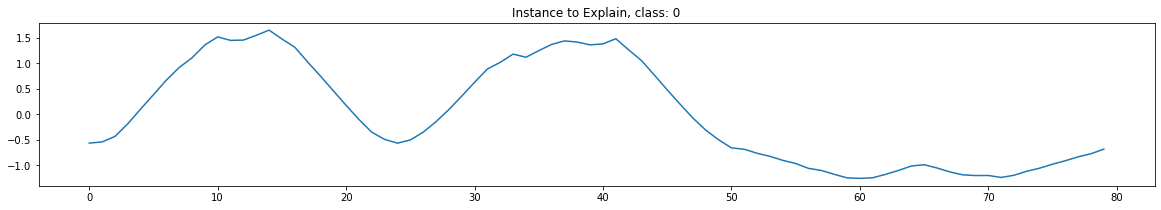

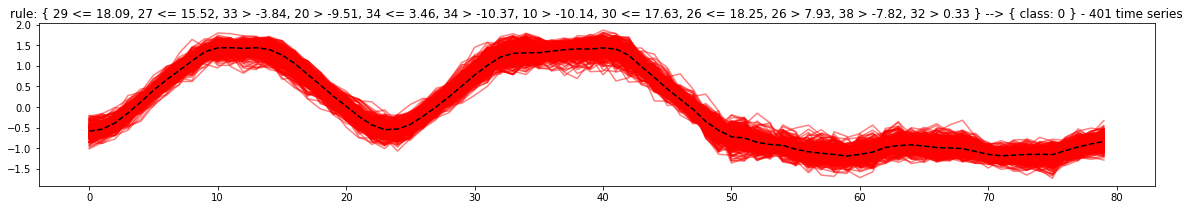

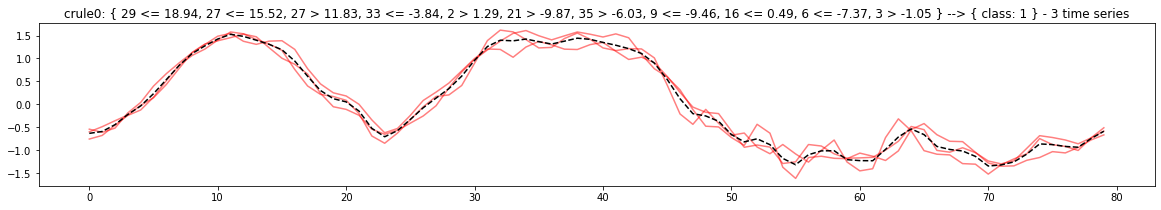

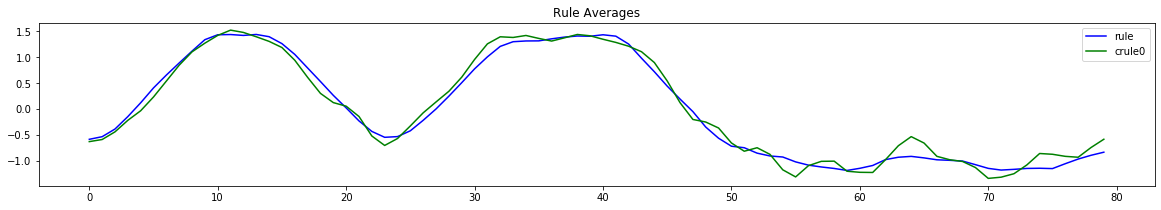

rule


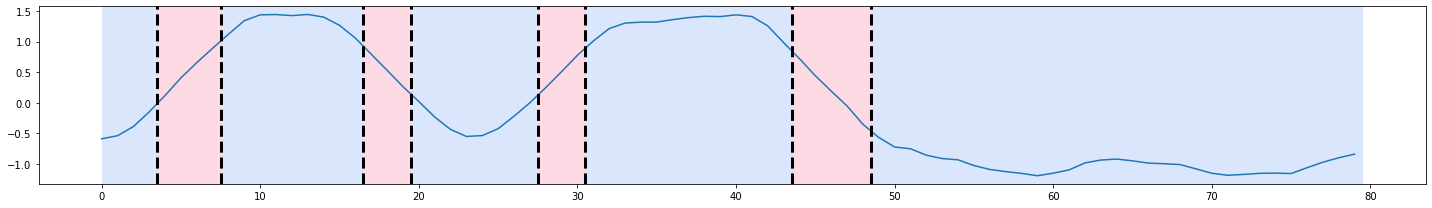

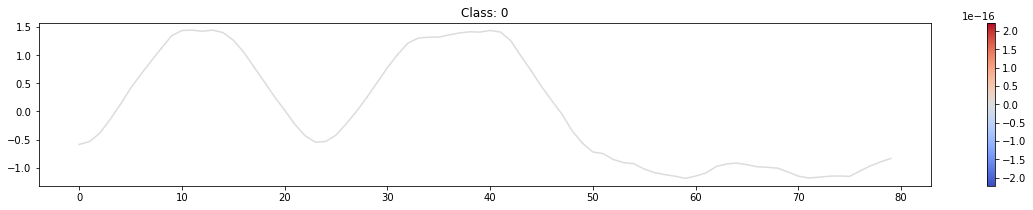

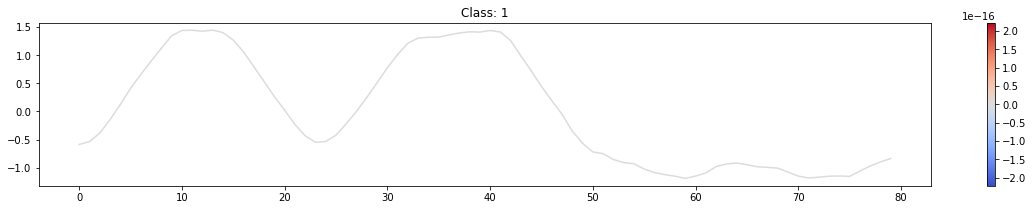

crule0


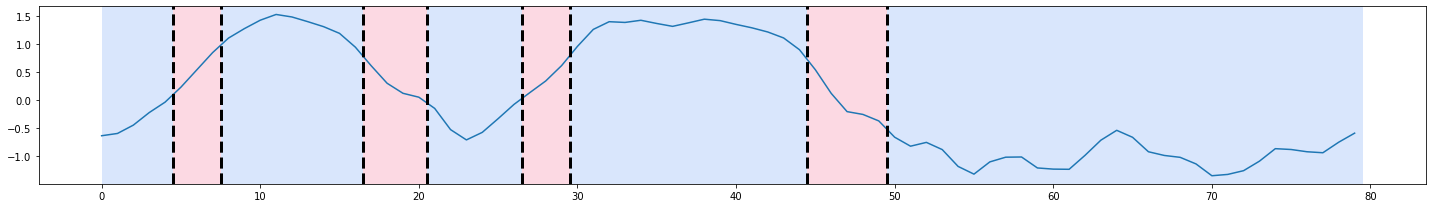

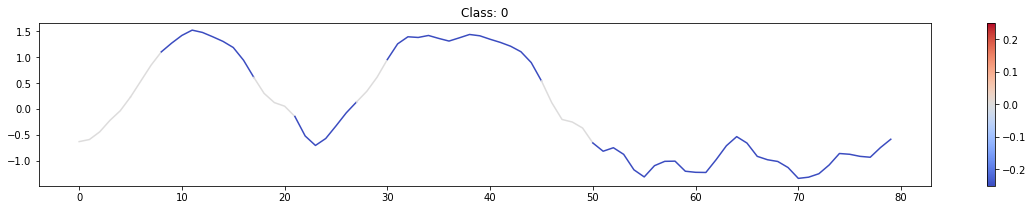

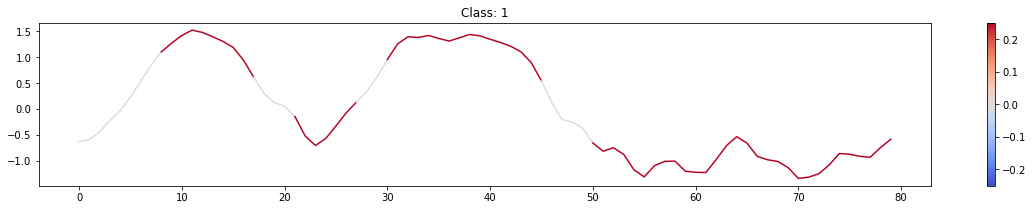

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.9s finished


rule
Rules used to predict sample 0: 
sample predicted class:  0
decision id node 0 : (shapelet n. 4 (distance = 0.0060800314) <= 0.041402459144592285)
decision id node 1 : (shapelet n. 4 (distance = 0.0060800314) <= 0.017328262329101562)


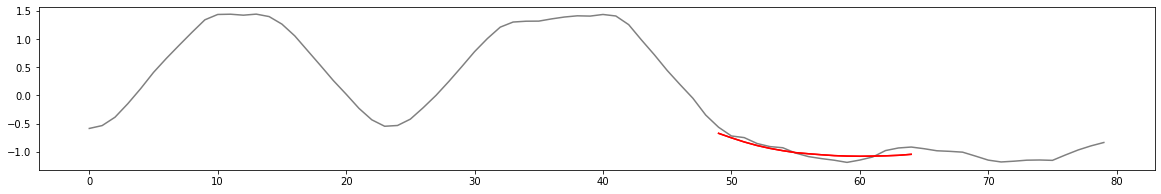

decision id node 0 : (shapelet n. 4 (distance = 0.0060800314) <= 0.041402459144592285)


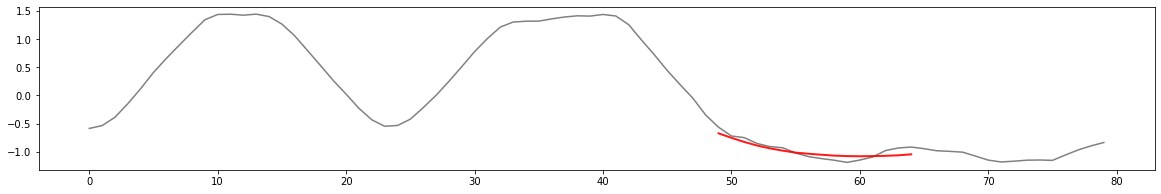

decision id node 1 : (shapelet n. 4 (distance = 0.0060800314) <= 0.017328262329101562)


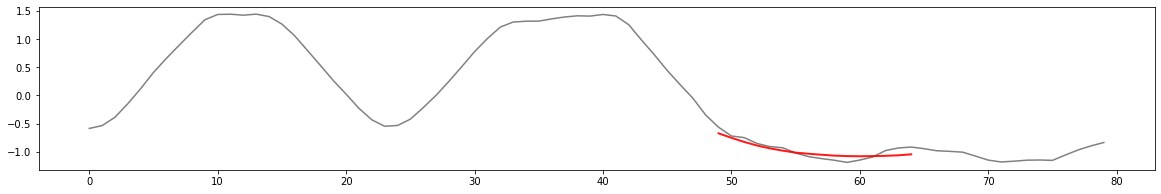

crule0
Rules used to predict sample 0: 
sample predicted class:  1
decision id node 0 : (shapelet n. 4 (distance = 0.03208661) <= 0.041402459144592285)
decision id node 1 : (shapelet n. 4 (distance = 0.03208661) > 0.017328262329101562)


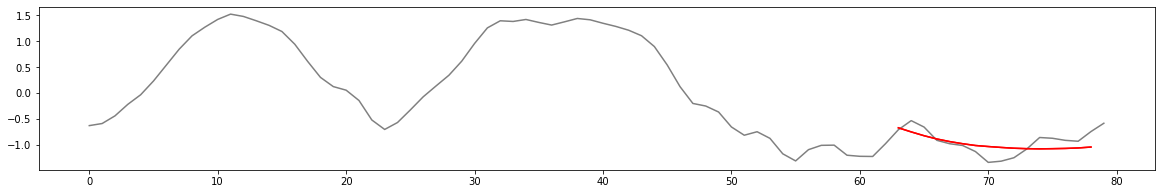

decision id node 0 : (shapelet n. 4 (distance = 0.03208661) <= 0.041402459144592285)


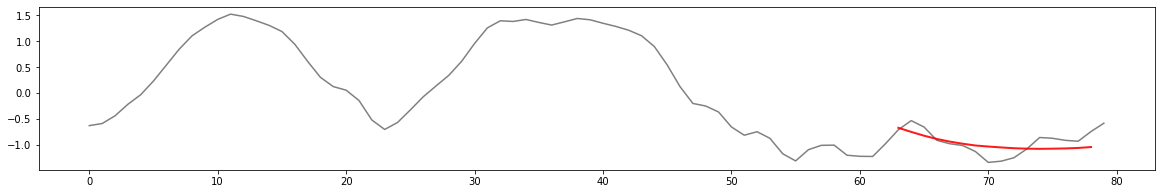

decision id node 1 : (shapelet n. 4 (distance = 0.03208661) > 0.017328262329101562)


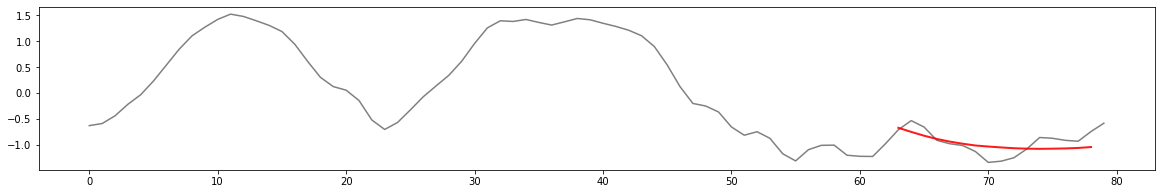

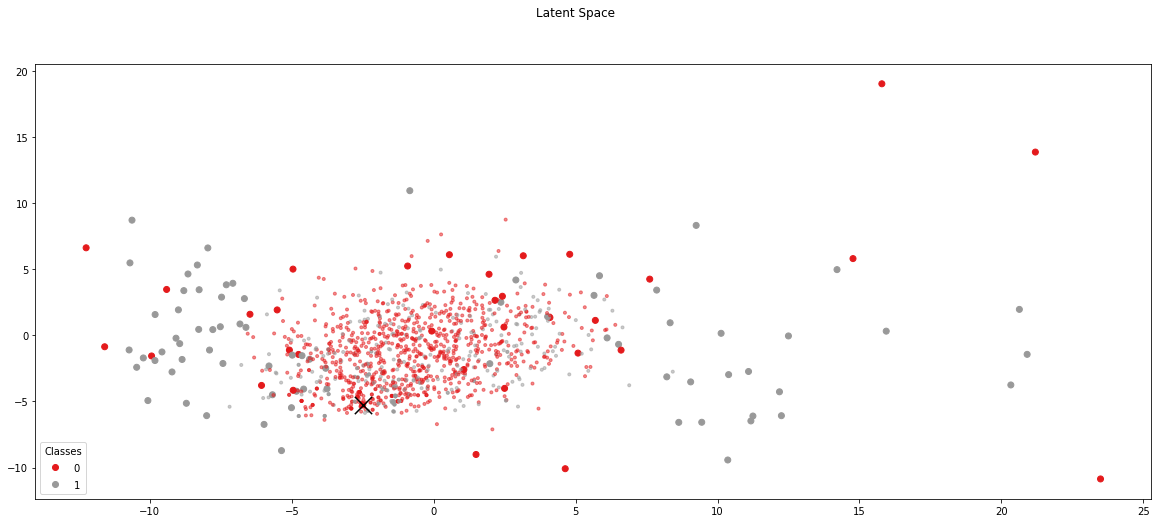

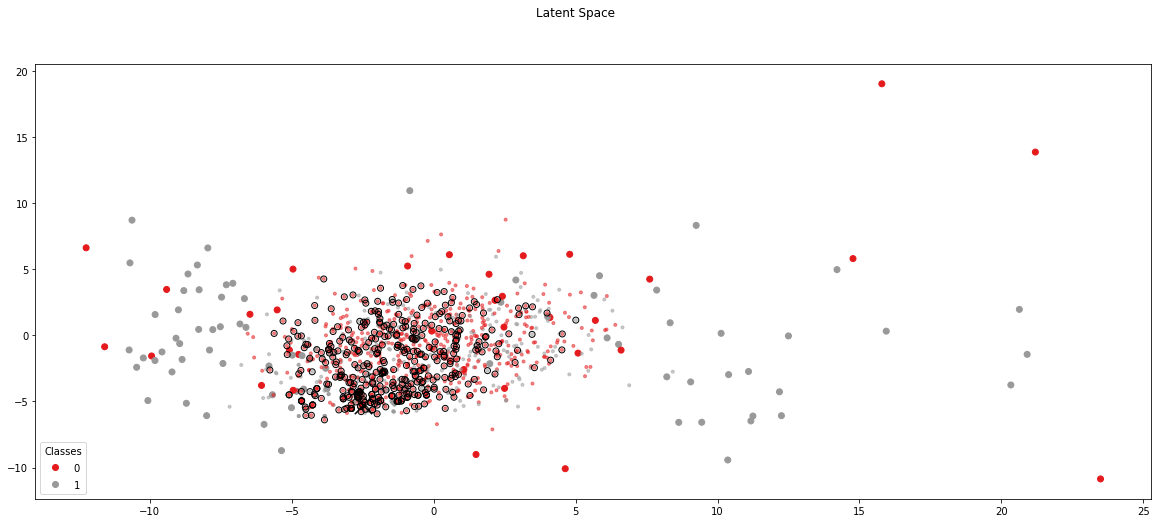

In [35]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )

## KNN

In [36]:
blackbox = knn

In [37]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [38]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 2
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [39]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	214   	0.737023	0.496654	0.993143
2  	220   	0.905823	0.496654	0.993143
3  	217   	0.923631	0.498109	0.993175
4  	205   	0.925638	0.498751	0.993175
5  	211   	0.925676	0.49807 	0.993175
6  	216   	0.927637	0.498675	0.993209
7  	210   	0.941485	0.498798	0.993209
8  	213   	0.931624	0.498621	0.99323 
9  	214   	0.947405	0.498125	0.993211
10 	213   	0.949401	0.498636	0.993211
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	212   	0.527375	0.499047	0.99302
2  	207   	0.59437 	0.498744	0.993088
3  	211   	0.669198	0.498573	0.993122
4  	201   	0.761808	0.498165	0.993072
5  	210   	0.805158	0.498006	0.993133
6  	222   	0.80516 	0.498405	0.993216
7  	213   	0.817047	0.498661	0.993216
8  	204   	0.815082	0.498135	0.993216
9  	217   	0.821027	0.498796	0.993216
10 	200   	0.824998	0.498354	0.993216
synthetic neighborhood class counts {0: 615, 1: 534}


In [40]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [41]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


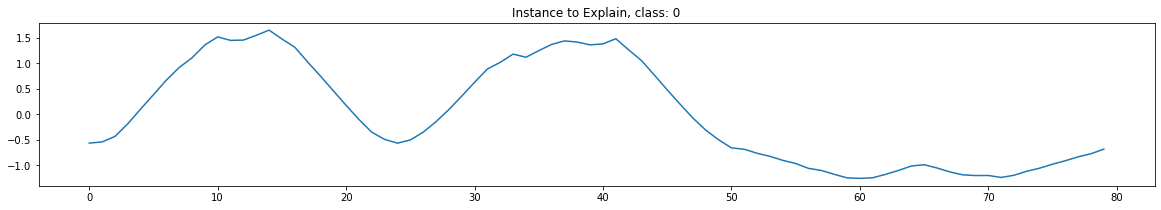

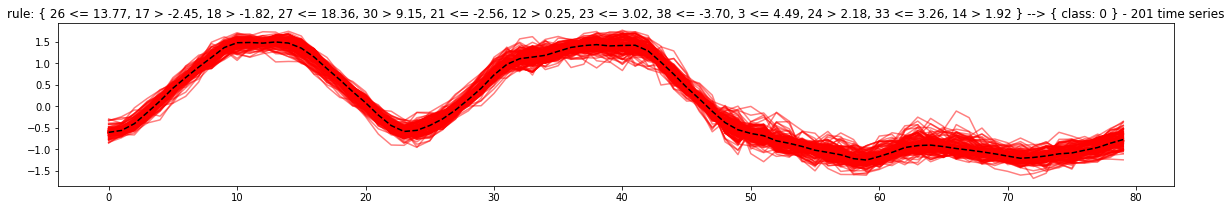

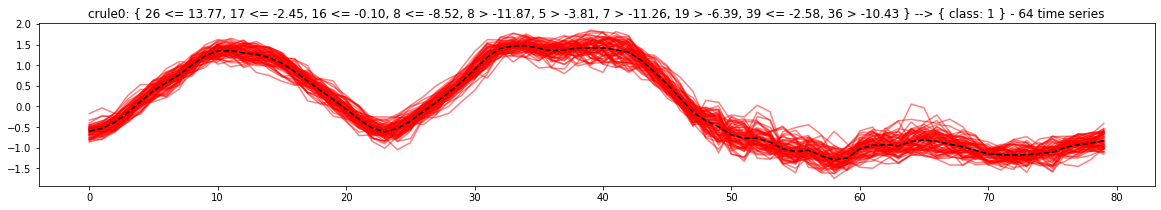

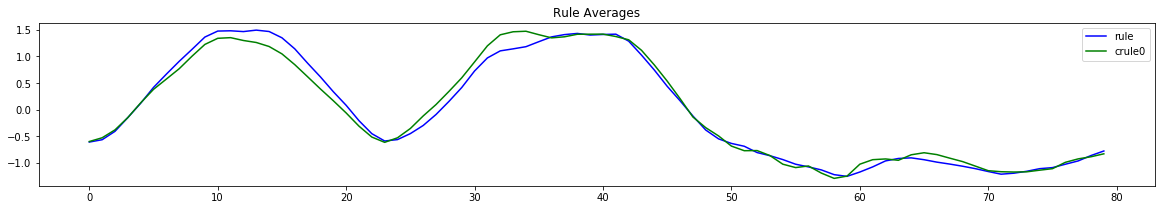

rule


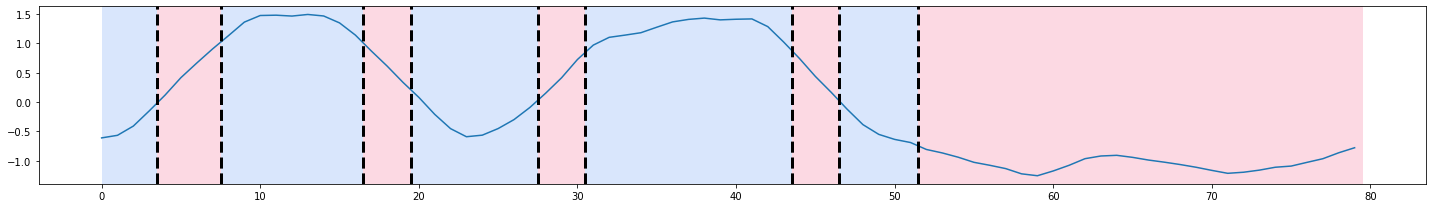

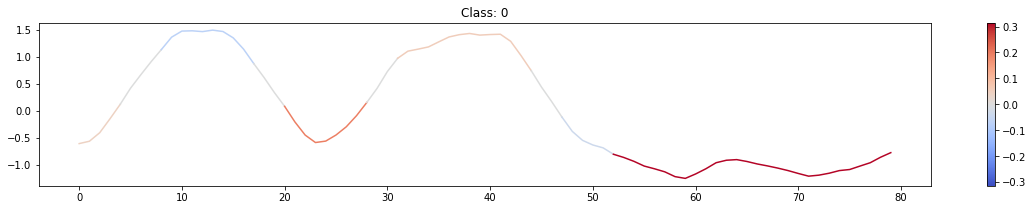

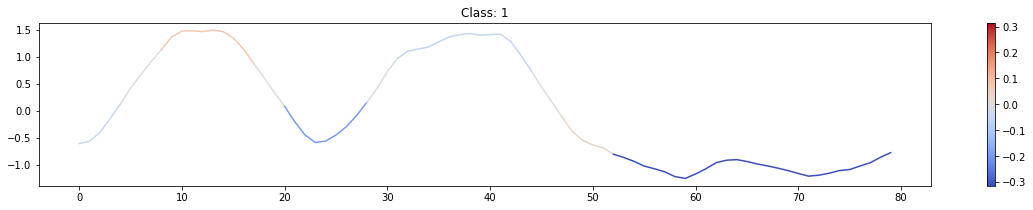

crule0


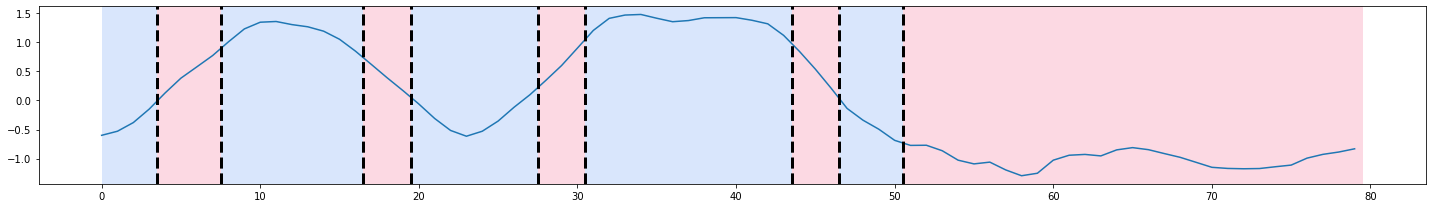

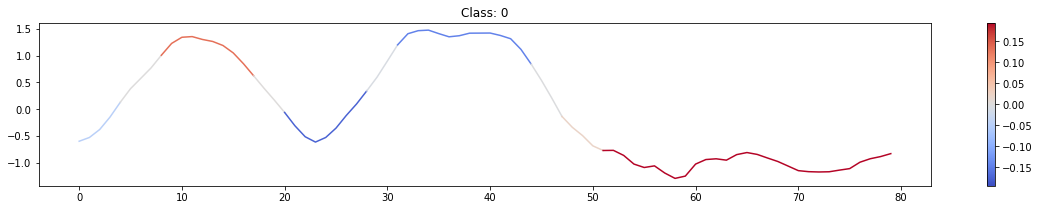

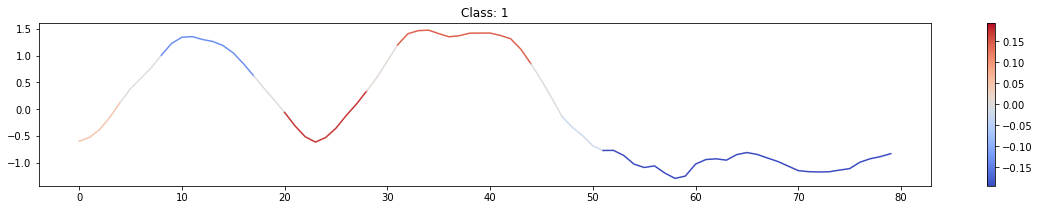

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.0s finished


rule
Rules used to predict sample 0: 
sample predicted class:  0
decision id node 0 : (shapelet n. 4 (distance = 0.01308465) <= 0.03643685579299927)
decision id node 1 : (shapelet n. 0 (distance = 0.02646184) <= 0.04120481014251709)
decision id node 2 : (shapelet n. 5 (distance = 0.009751558) <= 0.018719077110290527)
decision id node 3 : (shapelet n. 1 (distance = 0.004055977) > 0.0016821622848510742)
decision id node 5 : (shapelet n. 7 (distance = 0.03514564) <= 0.0354917049407959)


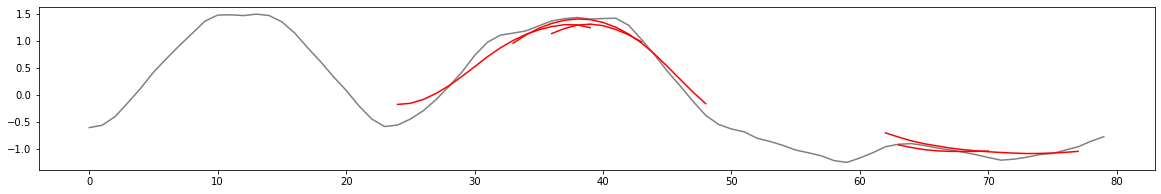

decision id node 0 : (shapelet n. 4 (distance = 0.01308465) <= 0.03643685579299927)


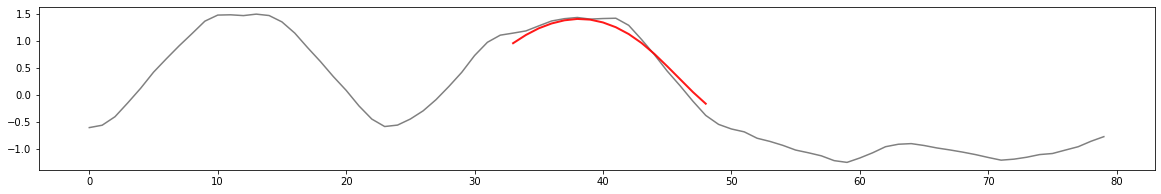

decision id node 1 : (shapelet n. 0 (distance = 0.02646184) <= 0.04120481014251709)


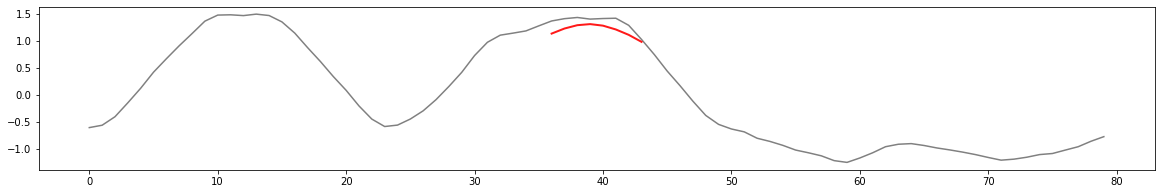

decision id node 2 : (shapelet n. 5 (distance = 0.009751558) <= 0.018719077110290527)


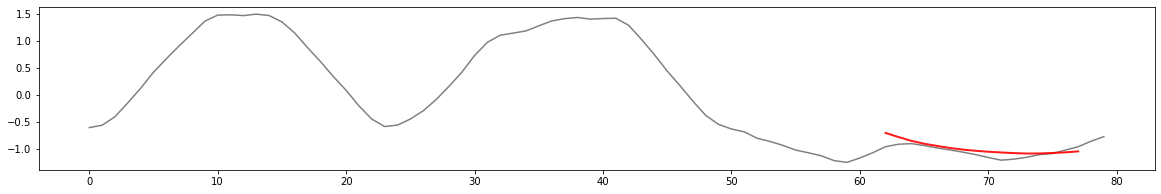

decision id node 3 : (shapelet n. 1 (distance = 0.004055977) > 0.0016821622848510742)


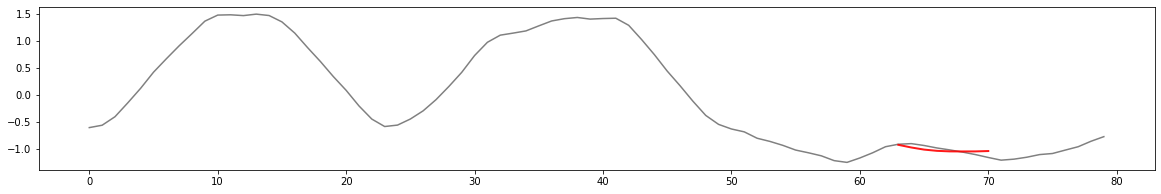

decision id node 5 : (shapelet n. 7 (distance = 0.03514564) <= 0.0354917049407959)


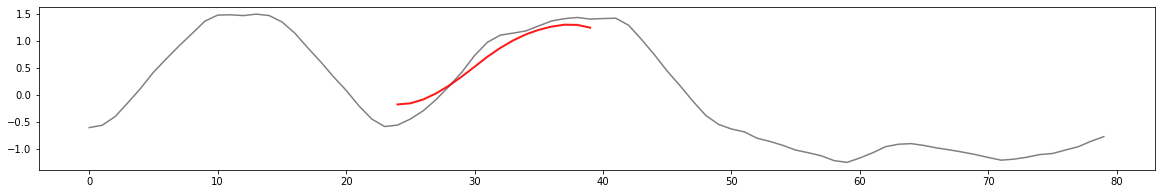

crule0
Rules used to predict sample 0: 
sample predicted class:  1
decision id node 0 : (shapelet n. 4 (distance = 0.028153062) <= 0.03643685579299927)
decision id node 1 : (shapelet n. 0 (distance = 0.004324198) <= 0.04120481014251709)
decision id node 2 : (shapelet n. 5 (distance = 0.010070324) <= 0.018719077110290527)
decision id node 3 : (shapelet n. 1 (distance = 0.008123398) > 0.0016821622848510742)
decision id node 5 : (shapelet n. 7 (distance = 0.039409995) > 0.0354917049407959)
decision id node 7 : (shapelet n. 7 (distance = 0.039409995) > 0.036514878273010254)
decision id node 9 : (shapelet n. 1 (distance = 0.008123398) > 0.0046710968017578125)
decision id node 11 : (shapelet n. 6 (distance = 0.0332278) <= 0.06637251377105713)


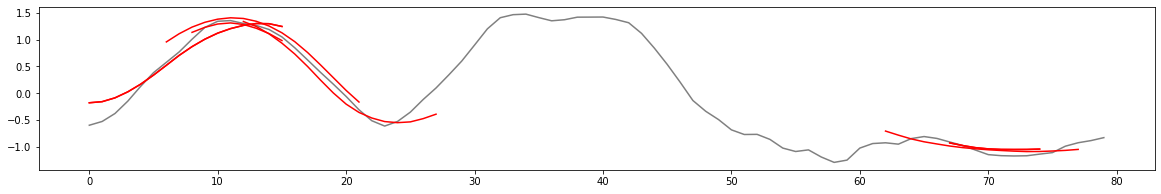

decision id node 0 : (shapelet n. 4 (distance = 0.028153062) <= 0.03643685579299927)


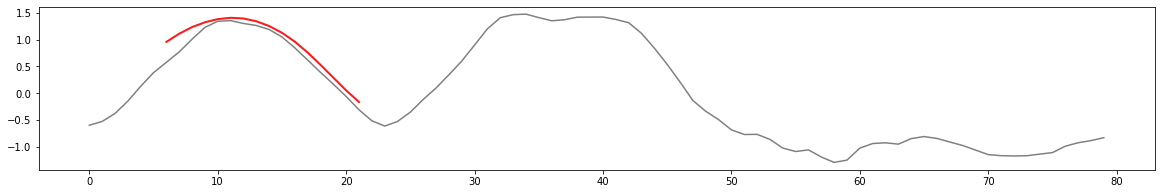

decision id node 1 : (shapelet n. 0 (distance = 0.004324198) <= 0.04120481014251709)


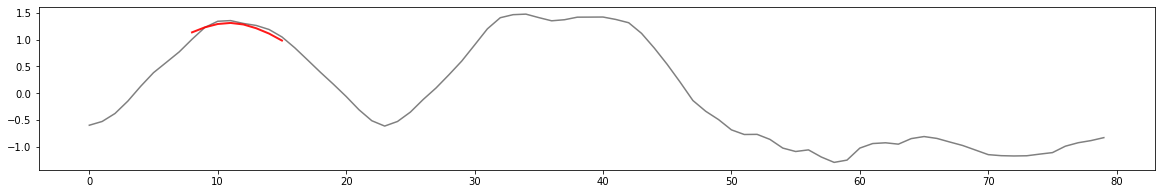

decision id node 2 : (shapelet n. 5 (distance = 0.010070324) <= 0.018719077110290527)


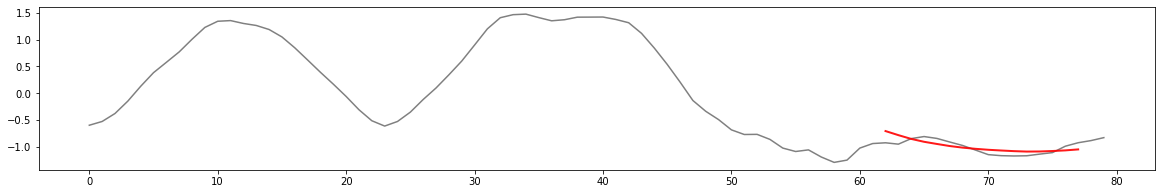

decision id node 3 : (shapelet n. 1 (distance = 0.008123398) > 0.0016821622848510742)


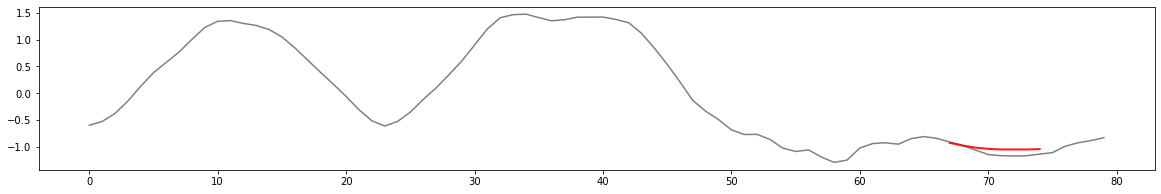

decision id node 5 : (shapelet n. 7 (distance = 0.039409995) > 0.0354917049407959)


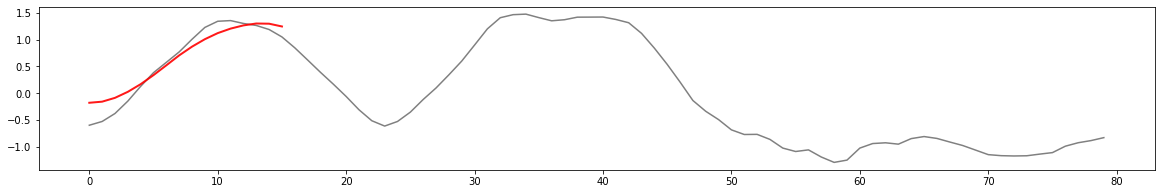

decision id node 7 : (shapelet n. 7 (distance = 0.039409995) > 0.036514878273010254)


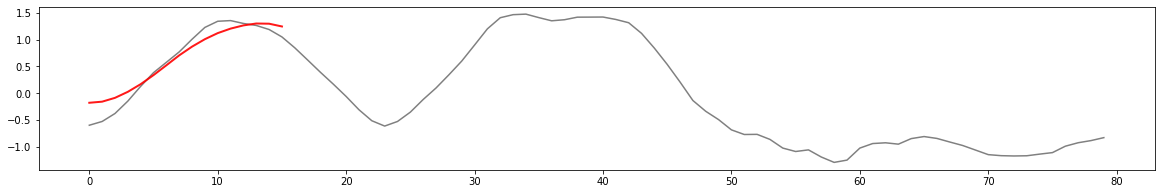

decision id node 9 : (shapelet n. 1 (distance = 0.008123398) > 0.0046710968017578125)


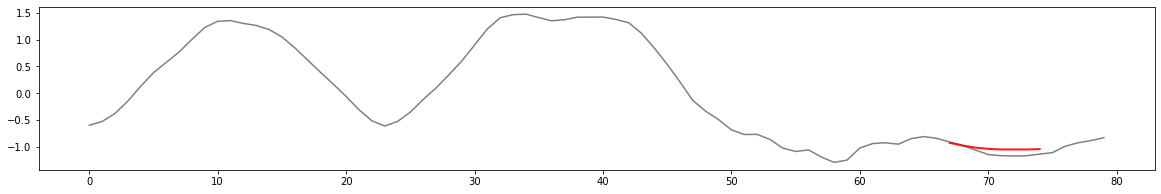

decision id node 11 : (shapelet n. 6 (distance = 0.0332278) <= 0.06637251377105713)


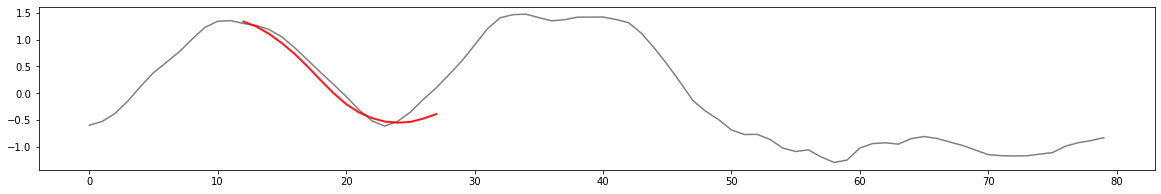

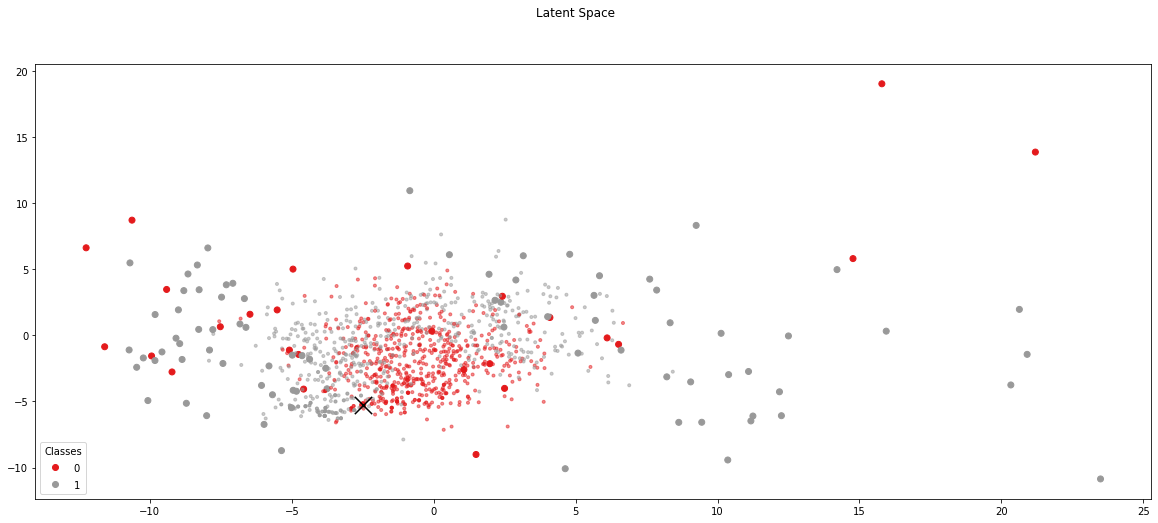

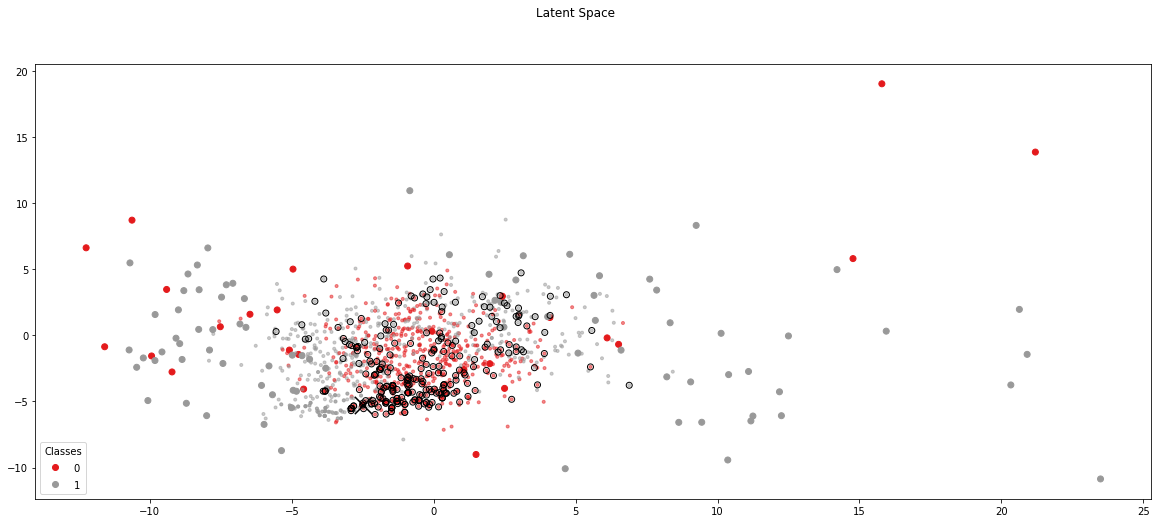

In [42]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )